# Set ROIs

This notebook allows you to make ROIs for a video without going through the entire pipeline. The example frame used as the image to set the ROIs is fetched using OpenCV's video reader.\
The functionality of this notebook is technically subsumed by the basic pipeline notebook.

**If your data is local**: Just specify the path to the video you want to draw ROIs on.

**If your data is on a server**: OpenCV's video reader allows for you to read just a single frame from a video file without transferring the entire thing IF the server directory is mounted. So we recommend mounting the server directory if possible to avoid transferring the entire file. This can be done with:
- Windows: https://support.microsoft.com/en-us/windows/map-a-network-drive-in-windows-29ce55d1-34e3-a7e2-4801-131475f9557d
- OSX: https://www.google.com/search?q=mount+network+drive+osx
- Linux: Use RClone CLI

In [1]:
# ALWAYS RUN THIS CELL
# widen jupyter notebook window
from IPython.display import display, HTML
display(HTML("<style>.container {width:95% !important; }</style>"))

%load_ext autoreload
%autoreload 2
import face_rhythm as fr

from pprint import pprint
from pathlib import Path

import cv2

import numpy as np
import torch
import matplotlib.pyplot
from tqdm import tqdm

fr.util.get_system_versions(verbose=True);

Operating System: Linux: 5.15.0-57-generic, #63~20.04.1-Ubuntu SMP Wed Nov 30 13:40:16 UTC 2022, x86_64, node: rich-L-CLASS
Conda Environment: FR
Python Version: 3.9.13
GCC Version: 9.4.0
PyTorch Version: 1.12.1+cpu
CUDA is not available
Numpy Version: 1.23.2
OpenCV Version: 4.6.0
face-rhythm Version: 0.1.0


## Set paths

In [98]:
directory_videos  = '/mnt/MICROSCOPE/Gyu/BMI_data/mouse_g1'
filename_strMatch = '.*/2022101[0-6].*cam4.*avi'  ## You can use regular expressions to search and match more complex strings
# filename_strMatch = 'cam4.*avi'  ## You can use regular expressions to search and match more complex strings


In [99]:
paths_videos = fr.helpers.find_paths(
    dir_outer=directory_videos,
    reMatch=filename_strMatch,  ## string to use to search for files in directory. Uses regular expressions!
    depth=5,  ## how many folders deep to search
)

display(paths_videos)

['/mnt/MICROSCOPE/Gyu/BMI_data/mouse_g1/20221010/camera_data/cam4/exp/cam42022-10-10T13_16_09.avi',
 '/mnt/MICROSCOPE/Gyu/BMI_data/mouse_g1/20221011/camera_data/cam4/exp/cam42022-10-11T14_12_33.avi',
 '/mnt/MICROSCOPE/Gyu/BMI_data/mouse_g1/20221012/camera_data/cam4/exp/cam42022-10-12T14_56_14.avi',
 '/mnt/MICROSCOPE/Gyu/BMI_data/mouse_g1/20221013/camera_data/cam4/exp/cam42022-10-13T18_14_35.avi',
 '/mnt/MICROSCOPE/Gyu/BMI_data/mouse_g1/20221014/camera_data/cam4/exp/cam42022-10-14T16_55_22.avi',
 '/mnt/MICROSCOPE/Gyu/BMI_data/mouse_g1/20221015/camera_data/cam4/exp/cam42022-10-16T13_11_38.avi',
 '/mnt/MICROSCOPE/Gyu/BMI_data/mouse_g1/20221016/camera_data/cam4/exp/cam42022-10-17T13_21_07.avi']

In [7]:
directory_save = r'/home/rich/Desktop/'

## Fetch image

In [8]:
vc = cv2.VideoCapture(paths_videos[0])
s, image = vc.read()

# Define ROIs

Either select new ROIs (`select_mode='gui'`), or import existing ROIs (`path_file=path_to_ROIs.h5_file`).\
Typically, you should make 1 or 2 ROIs. One for defining where the face points should be and one for cropping the frame.

FR: Initializing GUI...


<IPython.core.display.Javascript object>


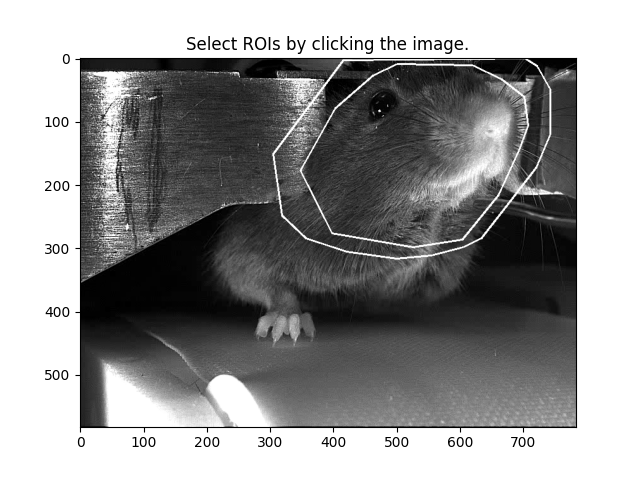

Button(description='Confirm ROI', style=ButtonStyle())

Button(description='New ROI', style=ButtonStyle())

mask_frames computed


In [9]:
# %matplotlib notebook
rois = fr.rois.ROIs(
    select_mode='gui',
    exampleImage=image,
    verbose=2
)

Save the `ROIs` object in the 'analysis_files' project folder

FR: Making points to track
FR: 768 points total


<IPython.core.display.Javascript object>


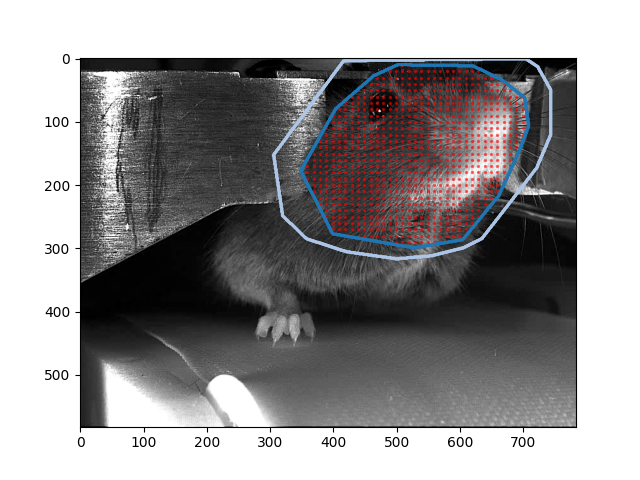

(<Figure size 640x480 with 1 Axes>, <AxesSubplot:>)

In [10]:
rois.make_points(rois[0], point_spacing=10)
rois.plot_rois()

In [11]:
# path_save = str(Path(directory_save) / 'ROIs.h5')
# rois.save_run_data(path_run_data=path_save, overwrite=True, verbose=1)

# Optional: Multisession alignment

The below code shows how to align the points from one 'template' session onto multiple other 'new' sessions.\
Steps:
1. Get example images from each session: `images`
2. Optionally adjust the local contrast of each example image to make: `images_toUse`
3. Instantiate the `ROI_Aligner` class and choose which OpenCV optical flow method to use: `aligner`
4. Perform non-rigid registration to warp the 'template' ROIs and points onto the example images from each session: `aligner.align_and_make_ROIs`
5. Retrieve the newly made `ROIs` class objects: `rois_objs_new = aligner.ROIs_objects_new`
6. Save the new `ROIs` class objects: `rois_objs_new[x].save_run_data()`
7. Visualize the results!

1. Get example images

In [25]:
images = {path: cv2.VideoCapture(path).read()[1] for path in tqdm(paths_videos)}


100%|█████████████████████████████████████████████| 8/8 [02:27<00:00, 18.38s/it]


2. Optionally adjust local contrast

In [26]:
use_CLAHE = False
images_toUse = [fr.helpers.clahe(im.mean(2), grid_size=2, clipLimit=0, normalize=True)[:,:,None] for im in images.values()] if use_CLAHE else list(images.values())


3. to 5. Register ROIs from template to new session images, then make new `ROIs` objects

In [28]:
aligner = fr.rois.ROI_Alinger(
    method='createOptFlow_DeepFlow',
    verbose=2,
)
aligner.align_and_make_ROIs(
    ROIs_object_template=rois,
    images_new=images_toUse,
    template_method='image',
    shifts=None,
    normalize=True,
)
rois_objs_new = aligner.ROIs_objects_new

Registering images...



100%|█████████████████████████████████████████████| 8/8 [00:03<00:00,  2.13it/s]


Warping point positions...



100%|█████████████████████████████████████████████| 8/8 [00:00<00:00, 31.75it/s]


Warping ROI outlines...



100%|█████████████████████████████████████████████| 8/8 [00:00<00:00, 16.39it/s]


Making mask images...



100%|█████████████████████████████████████████████| 8/8 [00:00<00:00, 26.40it/s]


Making ROIs objects...



100%|█████████████████████████████████████████████| 8/8 [00:00<00:00, 26.82it/s]


Warping images...



100%|█████████████████████████████████████████████| 8/8 [00:00<00:00, 84.43it/s]


look at the new `ROIs` objects we just made

In [29]:
display(rois_objs_new)

[ROIs object. Select mode: 'custom'. Number of ROIs: 2.,
 ROIs object. Select mode: 'custom'. Number of ROIs: 2.,
 ROIs object. Select mode: 'custom'. Number of ROIs: 2.,
 ROIs object. Select mode: 'custom'. Number of ROIs: 2.,
 ROIs object. Select mode: 'custom'. Number of ROIs: 2.,
 ROIs object. Select mode: 'custom'. Number of ROIs: 2.,
 ROIs object. Select mode: 'custom'. Number of ROIs: 2.,
 ROIs object. Select mode: 'custom'. Number of ROIs: 2.]

6. Save the new `ROIs` objects. These can be used to initialize the `ROIs` objects in each face-rhythm run.

In [30]:
for ii,rois_new in enumerate(rois_objs_new):
    path_save = str(Path(directory_save) / f'ROIs_{ii}.h5')
    rois_new.save_run_data(
        path_run_data=path_save,
        verbose=1
    )

FR WARNING: path_run_data file is expected to be named 'ROIs.h5' if it is part of a project. Please make sure this is correct.
FR Warning: Overwriting file. File: /home/rich/Desktop/ROIs_0.h5 already exists.
FR WARNING: path_run_data file is expected to be named 'ROIs.h5' if it is part of a project. Please make sure this is correct.
FR Warning: Overwriting file. File: /home/rich/Desktop/ROIs_1.h5 already exists.
FR WARNING: path_run_data file is expected to be named 'ROIs.h5' if it is part of a project. Please make sure this is correct.
FR Warning: Overwriting file. File: /home/rich/Desktop/ROIs_2.h5 already exists.
FR WARNING: path_run_data file is expected to be named 'ROIs.h5' if it is part of a project. Please make sure this is correct.
FR Warning: Overwriting file. File: /home/rich/Desktop/ROIs_3.h5 already exists.
FR WARNING: path_run_data file is expected to be named 'ROIs.h5' if it is part of a project. Please make sure this is correct.
FR Warning: Overwriting file. File: /home

7. Visualize!

<IPython.core.display.Javascript object>


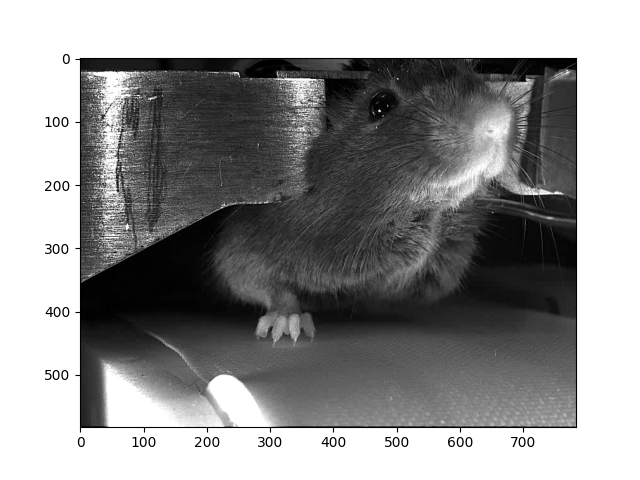

interactive(children=(IntSlider(value=0, description='i_frame', max=7), Output()), _dom_classes=('widget-inter…

In [31]:
fr.visualization.display_toggle_image_stack(aligner.images_warped, cmap='gray')

In [32]:
frame_visualizer = fr.visualization.FrameVisualizer(
    display=False,
    frame_height_width=images_toUse[0].shape[:2],
    point_sizes=3,
    points_colors=(255,0,0),
    alpha=0.5,
)

images_with_warped_points = [frame_visualizer.visualize_image_with_points(
    image=img,
    points=points,
) for img,points in zip(images_toUse, aligner.pointPositions_new)]

<IPython.core.display.Javascript object>


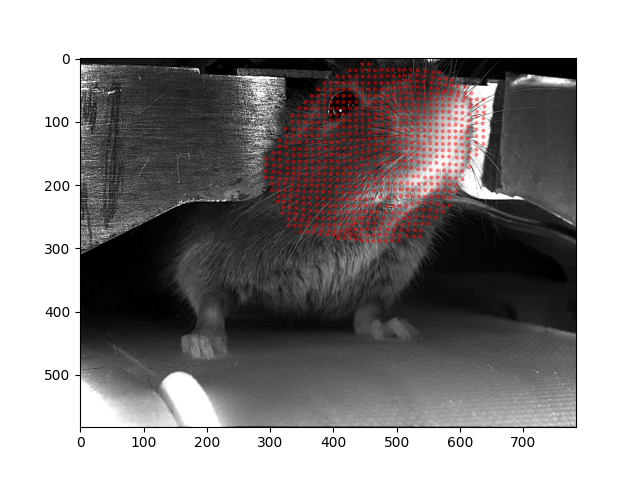

interactive(children=(IntSlider(value=0, description='i_frame', max=7), Output()), _dom_classes=('widget-inter…

In [33]:
fr.visualization.display_toggle_image_stack(images_with_warped_points)